# Data Wrangling with Behavioural Tasks
Starting point:
- 848 datasets (18 tasks per model (minus the NON_IDEAL_OUTPUTS)) with all logprobs for all answer alternatives of each subtask for all ~1.500 tasks. 

What does this script do
- Read all behavioural data sets
- normalise log-prob scores so that they are probabilities that sum up to 1 over all answer options
- filter out the probability that the LLm assigned to the answer option which the participant actually chose (for each round) (function more complicated than for survey tasks, because decision keys are only randomized letters, first have to merge data with itemlevel results of human data to infer which choices were high risk, then use those for weighing)
- again calculate weighted score per model per item/round over all participants answers
- add al to `all_data` dataframe and save

Specials:
- for BART or CCT we use already one step up aggregated data (instead of probs per pump decision we use per round number of pumps and the normalized probability scores per participant per round)
    - problem: kenne tatsächliche Zuordnung der Runden (also wann Balloon explodiert) nicht, also randomness Komponente, da die Runden pro Person miteinander gemittelt werden, obwohl sie nicht zusammen passen


Goal:
- first have one value per item per model
- then transform those values in "outcomes" for each subscale (like Frey did)
- Have 36 values per model! (one per (sub-) scale).

## Packages & Helpers

In [ ]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from utils import load_dataframes, filter_pred_prob
# load overall df
all_data = pd.read_csv("processed_data/items_per_LLM.csv")
#all_data = pd.read_csv("processed_data/items_per_LLM_random_simulation.csv")
#all_data = pd.read_csv("processed_data/items_per_LLM_semi_random_simulation.csv")


In [77]:
# Helpers

# filter out probability LLM assigned to real item answer  ------------------------------------------
def filter_pred_prob_including_key_logic(data, key1_column="box_1_key", key2_column= "box_2_key"):
    # Determine whether the human decision matches box_1 or box_2
    mask_box1 = data["human_decision"] == data[key1_column]
    mask_box2 = data["human_decision"] == data[key2_column]

    # Assign probability based on which box matches
    data["prob_pred"] = data["prob_1"].where(mask_box1, data["prob_2"].where(mask_box2, None))
    
    return data



# Funktion für Top-n gewichteten Score
def compute_top_n_weighted_score(group, n = 100, human_col = "decision_num"):
    # Sortiere die Zeilen nach Wahrscheinlichkeit absteigend
    top_n = group.sort_values("prob_pred", ascending=False).head(n)
    # Numerator = Summe von (Antwort * Wahrscheinlichkeit)
    numerator = (top_n[human_col] * top_n["prob_pred"]).sum()
    # Denominator = Summe von Wahrscheinlichkeiten der Top n
    denominator = top_n["prob_pred"].sum()
    return numerator / denominator if denominator > 0 else None

# produce df with one value per model per item for top n version --------------------------------------------------
def get_LLM_value_per_item_top_n(data, human_col = "decision_num", item_name = "round"):
    new_df = (
    data.groupby(["experiment", "model", item_name])[[human_col, "prob_pred"]]
      .apply(lambda group: compute_top_n_weighted_score(group, human_col=human_col))
      .reset_index(name="score_top_n")
    )
    return(new_df)


## BART TASK

In [78]:
# load data
BART_data = load_dataframes(task_name="BART")

Merged DataFrame shape: (74346712, 13)
Total models: 44


In [79]:
# normalise answer option sum to one
BART_data["prob_pump"] = np.exp(BART_data["log_prob_pump"])/(np.exp(BART_data["log_prob_pump"]) + np.exp(BART_data["log_prob_stop"]))
BART_data["prob_stop"] = np.exp(BART_data["log_prob_stop"])/(np.exp(BART_data["log_prob_pump"]) + np.exp(BART_data["log_prob_stop"]))

In [80]:
# filter out probability LLM assigned to real item answer 
BART_data=filter_pred_prob(BART_data, human_col = "human_decision")

In [81]:
# pro Balloon die durchschnittliche Wahrschenilichkeit für die tatsächliche menschliche Entscheidung berechnen (dann haben wir eine Probability pro Balloon pro Model)
avg_prob = BART_data.groupby(["experiment", "model", "participant", "round"])["prob_pred"].mean().reset_index()


In [82]:
# pro Balloon die number an Pumps extrahieren
max_decision = BART_data.groupby(["experiment", "model", "participant", "round"])["decision_num"].max().reset_index()


In [83]:
# merge the two aggregated numbers (pred_prob and decision_num)per person in one df
summary = pd.merge(avg_prob, max_decision, on=["experiment", "model", "participant", "round"])


In [84]:
# pro Balloon die Probability mal die Number of Pumps, das über Menschen normalisieren und am Ende number an Pumps pro Balloon pro Model haben
def get_LLM_value_per_item(data):
    grouped = data.groupby(["experiment", "model", "round"])
    score = (grouped["decision_num"].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum())
             / grouped["prob_pred"].sum())
    return score.reset_index(name="score")


model_item_scores_BART = get_LLM_value_per_item(summary)
model_item_scores_BART_top_n = get_LLM_value_per_item_top_n(summary)

# Merge them on the grouping keys
model_item_scores_BART = model_item_scores_BART.merge(
    model_item_scores_BART_top_n,
    on=["experiment", "model", "round"],
    how="inner" 
)


In [85]:
# rename BART round column to "item" to fit to all_data
model_item_scores_BART = model_item_scores_BART.rename(columns = {"round": "item"})

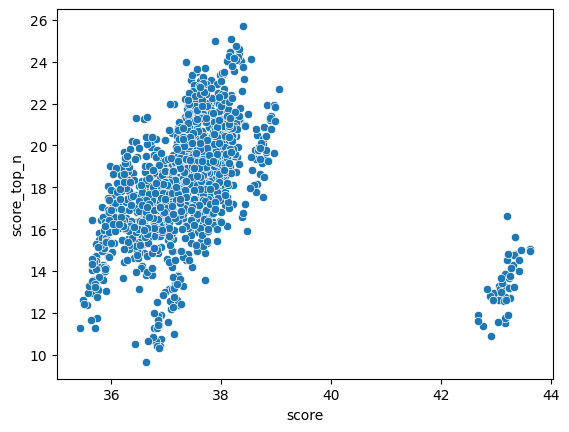

In [86]:
# plot
sns.scatterplot(data=model_item_scores_BART, x='score', y='score_top_n')
plt.show()

In [87]:
# add_new_df
all_data = pd.concat([all_data, model_item_scores_BART], ignore_index=True)


### BART Detour for comparison

- Use human DVs (BART)
- calc avg probability per participant (over all balloons (i.e. rounds))
- weigh over all participants
- outcome: one DV BART value per model
    - (calc avg decision_num over 30 balloons per model in model_item_scores_BART to also have one DV BART) Compare the two methods

In [88]:
# load human data (for BART DV per person)
BART_human_data = pd.read_csv("orig_human_data/bart.csv")


In [89]:
# calculate avg probability per participant
avg_prob_per_participant = BART_data.groupby(["experiment", "model", "participant"])["prob_pred"].mean().reset_index()


In [90]:
# merge human DV with probability per participant on participant
avg_prob_per_participant = pd.merge(avg_prob_per_participant, 
                                    BART_human_data[["partid", "pumps"]], 
                                    left_on="participant",
                                    right_on="partid",
                                    how = "inner")



In [91]:
# calculate DV per model
def get_LLM_value_per_item_aggregated(data, dv = "pumps"):
    grouped = data.groupby(["experiment", "model"])
    score = (grouped[dv].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum())
             / grouped["prob_pred"].sum())
    return score.reset_index(name="score")

model_item_scores_BART_aggregated = get_LLM_value_per_item_aggregated(avg_prob_per_participant)


In [92]:
# for comparison calculate BART DV value per model (other strategy)
model_item_scores_BART_final_DV = model_item_scores_BART.groupby(["experiment", "model"])["score"].mean().reset_index()


In [93]:
# merge two final DV dfs for comparison
final_BART_comparison_df = pd.merge(model_item_scores_BART_final_DV, 
                                    model_item_scores_BART_aggregated, 
                                    on=["experiment","model"],
                                    how = "inner",
                                    suffixes = ("_per_item", "_per_participant"))

final_BART_comparison_df

,experiment,model,score_per_item,score_per_participant
0,BART task,Apertus-70B-Instruct-2509,37.444859,36.777393
1,BART task,Apertus-8B-Instruct-2509,37.444491,36.783400
2,BART task,Falcon-3-10B-Instruct,37.460065,36.775398
3,BART task,Falcon-3-1B-Instruct,37.460536,36.778330
4,BART task,Falcon-3-7B-Instruct,37.466918,36.790822
5,BART task,LFM2-1.2B,37.439128,36.779292
6,BART task,LFM2-2.6B,37.438582,36.771670
7,BART task,LFM2-8B-A1B,37.437386,36.773186
8,BART task,Llama-3.1-70B-Instruct,37.507212,36.786967
9,BART task,Llama-3.1-8B-Instruct,37.398504,36.772050


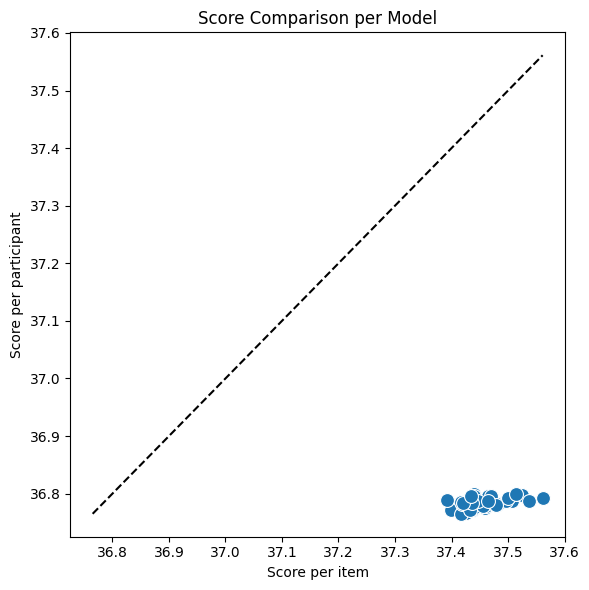

In [94]:
# plot
plt.figure(figsize=(6, 6))
sns.scatterplot(data=final_BART_comparison_df, x='score_per_item', y='score_per_participant',  s=100)

# equality line
plt.plot([final_BART_comparison_df[['score_per_item', 'score_per_participant']].min().min(),
          final_BART_comparison_df[['score_per_item', 'score_per_participant']].max().max()],
         [final_BART_comparison_df[['score_per_item', 'score_per_participant']].min().min(),
          final_BART_comparison_df[['score_per_item', 'score_per_participant']].max().max()],
         'k--', label='Equal scores')

plt.xlabel('Score per item')
plt.ylabel('Score per participant')
plt.title('Score Comparison per Model')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## CCT TASK

In [95]:
# load data
CCT_data = load_dataframes(task_name="CCT")

Merged DataFrame shape: (23305362, 16)
Total models: 38


In [96]:
# normalise answer option sum to one
CCT_data["prob_flip"] = np.exp(CCT_data["log_prob_flip"])/(np.exp(CCT_data["log_prob_flip"]) + np.exp(CCT_data["log_prob_stop"]))
CCT_data["prob_stop"] = np.exp(CCT_data["log_prob_stop"])/(np.exp(CCT_data["log_prob_flip"]) + np.exp(CCT_data["log_prob_stop"]))

In [97]:
# filter out probability LLM assigned to real item answer 
CCT_data=filter_pred_prob(CCT_data, human_col = "human_decision")

In [98]:
# pro round die durchschnittliche Wahrschenilichkeit für die tatsächliche menschliche Entscheidung berechnen (dann haben wir eine Probability pro round pro Model)
avg_prob_CCT = CCT_data.groupby(["experiment", "model", "participant", "round"])["prob_pred"].mean().reset_index()


In [99]:
# pro Balloon die number an Pumps extrahieren
max_decision_CCT = CCT_data.groupby(["experiment", "model", "participant", "round"])["decision_num"].max().reset_index()


In [100]:
# merge the two aggregated numbers (pred_prob and decision_num)per person in one df
summary_CCT = pd.merge(avg_prob_CCT, max_decision_CCT, on=["experiment", "model", "participant", "round"])


In [101]:
# pro round die Probability mal die decision_num, das über Menschen normalisieren und am Ende number an decisions pro round pro Model haben
model_item_scores_CCT = get_LLM_value_per_item(summary_CCT)

model_item_scores_CCT_top_n = get_LLM_value_per_item_top_n(summary_CCT)

# Merge them on the grouping keys
model_item_scores_CCT = model_item_scores_CCT.merge(
    model_item_scores_CCT_top_n,
    on=["experiment", "model", "round"],
    how="inner" 
)

In [102]:
# rename CCT round column to "item" to fit to all_data
model_item_scores_CCT = model_item_scores_CCT.rename(columns = {"round": "item"})

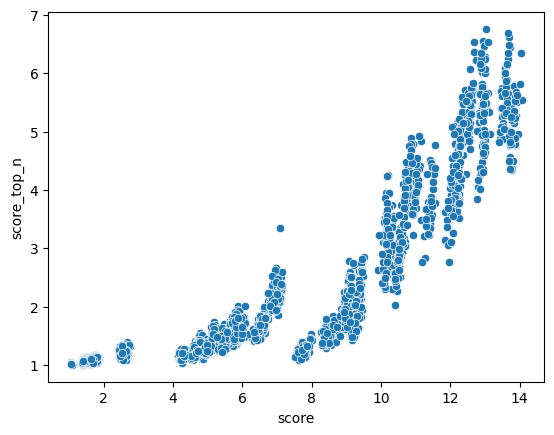

In [103]:
# plot
sns.scatterplot(data=model_item_scores_CCT, x='score', y='score_top_n')
plt.show()

In [104]:
# add_new_df
all_data = pd.concat([all_data, model_item_scores_CCT], ignore_index=True)


### CCT Detour 

In [105]:
# load human data (for CCT DV per person)
CCT_human_data = pd.read_csv("orig_human_data/cct_overt.csv")


In [106]:
# calculate avg probability per participant
avg_prob_per_participant_CCT = CCT_data.groupby(["experiment", "model", "participant"])["prob_pred"].mean().reset_index()


In [107]:
# merge human DV with probability per participant on participant
avg_prob_per_participant_CCT = pd.merge(avg_prob_per_participant_CCT, 
                                    CCT_human_data[["partid", "CCTncards"]], 
                                    left_on="participant",
                                    right_on="partid",
                                    how = "inner")



In [108]:
# calculate DV per model
model_item_scores_CCT_aggregated = get_LLM_value_per_item_aggregated(avg_prob_per_participant_CCT, dv="CCTncards")

In [109]:
# for comparison calculate CCT DV value per model (other strategy)
model_item_scores_CCT_final_DV = model_item_scores_CCT.groupby(["experiment", "model"])["score"].sum().reset_index()


In [110]:
# merge two final DV dfs for comparison
final_CCT_comparison_df = pd.merge(model_item_scores_CCT_final_DV, 
                                    model_item_scores_CCT_aggregated, 
                                    on=["experiment","model"],
                                    how = "inner",
                                    suffixes = ("_per_item", "_per_participant"))

final_CCT_comparison_df

,experiment,model,score_per_item,score_per_participant
0,CCT task,Apertus-8B-Instruct-2509,448.309598,414.118200
1,CCT task,Falcon-3-10B-Instruct,448.302397,413.837330
2,CCT task,Falcon-3-1B-Instruct,448.256125,414.113969
3,CCT task,Falcon-3-7B-Instruct,448.619421,414.165899
4,CCT task,LFM2-1.2B,447.427861,413.561187
5,CCT task,LFM2-2.6B,448.135152,413.994277
6,CCT task,LFM2-8B-A1B,449.054561,414.338259
7,CCT task,Llama-3.1-70B-Instruct,447.939619,414.005209
8,CCT task,Llama-3.1-8B-Instruct,448.403561,413.655893
9,CCT task,Llama-3.2-1B-Instruct,448.574462,414.118130


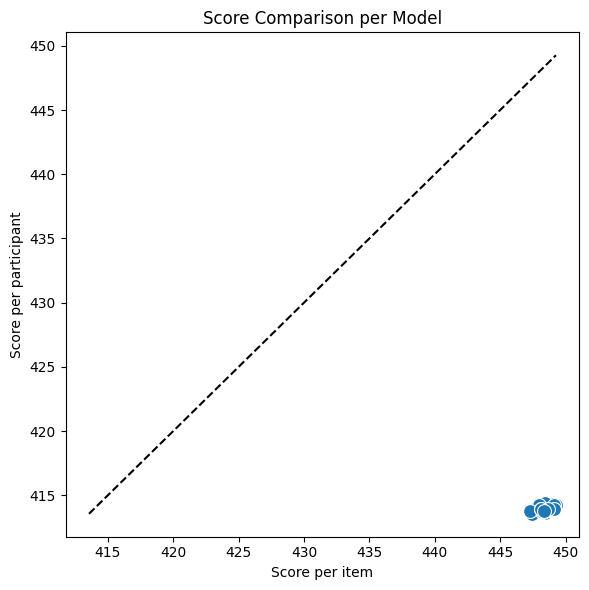

In [111]:
# plot
plt.figure(figsize=(6, 6))
sns.scatterplot(data=final_CCT_comparison_df, x='score_per_item', y='score_per_participant',  s=100)

# equality line
plt.plot([final_CCT_comparison_df[['score_per_item', 'score_per_participant']].min().min(),
          final_CCT_comparison_df[['score_per_item', 'score_per_participant']].max().max()],
         [final_CCT_comparison_df[['score_per_item', 'score_per_participant']].min().min(),
          final_CCT_comparison_df[['score_per_item', 'score_per_participant']].max().max()],
         'k--', label='Equal scores')

plt.xlabel('Score per item')
plt.ylabel('Score per participant')
plt.title('Score Comparison per Model')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## DFD TASK

In [112]:
# load data
DFD_data = load_dataframes(task_name="DFD")
DFD_human_data = pd.read_csv("orig_human_data/dfd_perprob.csv")

Merged DataFrame shape: (554576, 9)
Total models: 46


In [113]:
DFD_human_data["gamble_lab"].unique()

array(['he04_6inv', 'he04_1', 'he04_5', 'he04_6', 'he04_3', 'he04_2',
       'he04_4', 'he04_2inv'], dtype=object)

In [114]:
# normalise answer option sum to one
DFD_data["prob_1"] = np.exp(DFD_data["log_prob_box_1"])/(np.exp(DFD_data["log_prob_box_1"]) + np.exp(DFD_data["log_prob_box_2"]))
DFD_data["prob_2"] = np.exp(DFD_data["log_prob_box_2"])/(np.exp(DFD_data["log_prob_box_1"]) + np.exp(DFD_data["log_prob_box_2"]))

In [115]:
# filter out probability LLM assigned to real item answer 
DFD_data=filter_pred_prob_including_key_logic(DFD_data)

In [116]:
# Merge only selected columns from DFD_human_data
DFD_data = DFD_data.merge(
    DFD_human_data[["partid", "gamble_ind", "gamble_lab", "H", "R"]],
    left_on=["participant", "round"],
    right_on=["partid", "gamble_ind"],
    how="left"
)

# Drop duplicate key columns
DFD_data = DFD_data.drop(columns=["partid", "gamble_ind"])


In [117]:
# produce df with one value per model per item -------------------------------------------------------
def get_LLM_value_per_item(data):
    grouped = data.groupby(["experiment", "model", "gamble_lab"])
    prob_sum = grouped["prob_pred"].sum()
    
    # compute weighted means
    scoreH = (grouped["H"].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum()) / prob_sum)
    scoreR = (grouped["R"].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum()) / prob_sum)
    
    # combine into one DataFrame
    result = pd.concat([scoreH, scoreR], axis=1).reset_index()
    result.columns = ["experiment", "model", "gamble_lab", "H_score", "score"]
    
    return result


model_item_scores_DFD = get_LLM_value_per_item(DFD_data)


model_item_scores_DFD_top_n = get_LLM_value_per_item_top_n(DFD_data, human_col="R", item_name="gamble_lab")

# Merge them on the grouping keys
model_item_scores_DFD = model_item_scores_DFD.merge(
    model_item_scores_DFD_top_n,
    on=["experiment", "model", "gamble_lab"],
    how="inner" 
)

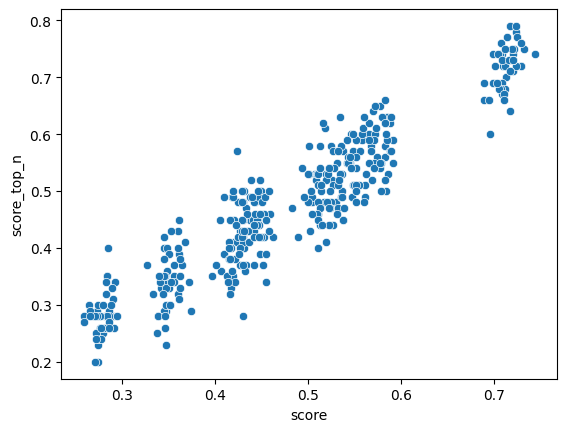

In [118]:
# plot
sns.scatterplot(data=model_item_scores_DFD, x='score', y='score_top_n')
plt.show()

In [119]:
# rename DFD gamble_lab column to "item" to fit to all_data
model_item_scores_DFD = model_item_scores_DFD.rename(columns = {"gamble_lab": "item"})

In [120]:
# Adding task specific categories to save in all data

# add item categories, some where loss and some where win decisions
item_to_category = {
    'he04_6inv': 'loss', 'he04_1': 'gain', 'he04_5': 'gain', 'he04_6': 'gain', 'he04_3': 'loss', 'he04_2': 'gain',
       'he04_4': 'loss', 'he04_2inv': 'loss'
}

model_item_scores_DFD["category"] = model_item_scores_DFD["item"].map(item_to_category)


In [121]:
# add_new_df
all_data = pd.concat([all_data, model_item_scores_DFD], ignore_index=True)


## DFE TASK

In [122]:
# load data
DFE_data = load_dataframes(task_name="DFE")
DFE_human_data = pd.read_csv("orig_human_data/dfe_perprob.csv")

Merged DataFrame shape: (458052, 9)
Total models: 38


In [123]:
# normalise answer option sum to one
DFE_data["prob_1"] = np.exp(DFE_data["log_prob_box_1"])/(np.exp(DFE_data["log_prob_box_1"]) + np.exp(DFE_data["log_prob_box_2"]))
DFE_data["prob_2"] = np.exp(DFE_data["log_prob_box_2"])/(np.exp(DFE_data["log_prob_box_1"]) + np.exp(DFE_data["log_prob_box_2"]))

In [124]:
# filter out probability LLM assigned to real item answer 
DFE_data=filter_pred_prob_including_key_logic(DFE_data)

In [125]:
# Merge only selected columns from DFD_human_data
DFE_data = DFE_data.merge(
    DFE_human_data[["partid", "gamble_ind", "gamble_lab", "R", "Rexp"]],
    left_on=["participant", "round"],
    right_on=["partid", "gamble_ind"],
    how="left"
)

# Drop duplicate key columns
DFE_data = DFE_data.drop(columns=["partid", "gamble_ind"])


In [126]:
# produce df with one value per model per item -------------------------------------------------------
def get_LLM_value_per_item(data):
    grouped = data.groupby(["experiment", "model", "gamble_lab"])
    prob_sum = grouped["prob_pred"].sum()
    
    # compute weighted means
    scoreR = (grouped["R"].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum()) / prob_sum)
    scoreRexp = (grouped["Rexp"].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum()) / prob_sum)
    
    # combine into one DataFrame
    result = pd.concat([scoreR, scoreRexp], axis=1).reset_index()
    result.columns = ["experiment", "model", "gamble_lab", "score_expected", "score"]
    
    return result


model_item_scores_DFE = get_LLM_value_per_item(DFE_data)

model_item_scores_DFE_top_n = get_LLM_value_per_item_top_n(DFE_data, human_col="Rexp", item_name="gamble_lab")

# Merge them on the grouping keys
model_item_scores_DFE = model_item_scores_DFE.merge(
    model_item_scores_DFE_top_n,
    on=["experiment", "model", "gamble_lab"],
    how="inner" 
)

In [127]:
# # flip back answers that where reverse coded - wrong after all, because I multiplied it with whether human took risky choice that is already all in same direction
# mask = model_item_scores_DFE["gamble_lab"].isin(["he04_2inv", "he04_6inv"])
# model_item_scores_DFE.loc[mask, "score"] = 1 - model_item_scores_DFE.loc[mask, "score"]
# model_item_scores_DFE.loc[mask, "score_top_n"] = 1 - model_item_scores_DFE.loc[mask, "score_top_n"]


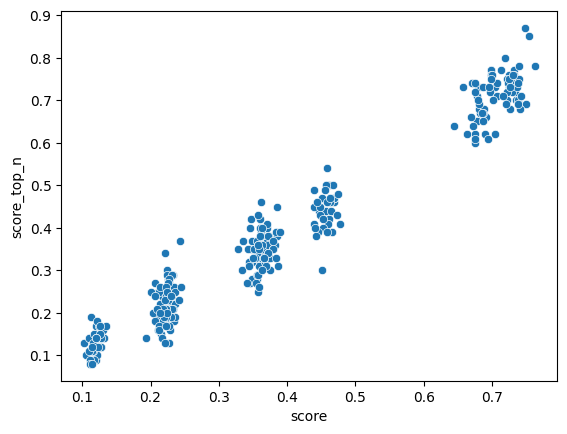

In [128]:
# plot
sns.scatterplot(data=model_item_scores_DFE, x='score', y='score_top_n')
plt.show()

In [129]:
# rename DFE gamble_lab column to "item" to fit to all_data
model_item_scores_DFE = model_item_scores_DFE.rename(columns = {"gamble_lab": "item"})

In [130]:
# add category like in DFD
model_item_scores_DFE["category"] = model_item_scores_DFE["item"].map(item_to_category)


In [131]:
# add_new_df
all_data = pd.concat([all_data, model_item_scores_DFE], ignore_index=True)

## LOT TASK

In [132]:
# load data
LOT_data = load_dataframes(task_name="LOT")
LOT_human_data = pd.read_csv("orig_human_data/lotteries.csv")

Merged DataFrame shape: (1733050, 9)
Total models: 46


In [133]:
# normalise answer option sum to one
LOT_data["prob_1"] = np.exp(LOT_data["log_prob_box_1"])/(np.exp(LOT_data["log_prob_box_1"]) + np.exp(LOT_data["log_prob_box_2"]))
LOT_data["prob_2"] = np.exp(LOT_data["log_prob_box_2"])/(np.exp(LOT_data["log_prob_box_1"]) + np.exp(LOT_data["log_prob_box_2"]))

In [134]:
# filter out probability LLM assigned to real item answer 
LOT_data=filter_pred_prob_including_key_logic(LOT_data)

In [135]:
# Merge only selected columns from DFD_human_data
LOT_data = LOT_data.merge(
    LOT_human_data[["partid", "Dec_ID", "R"]],
    left_on=["participant", "round"],
    right_on=["partid", "Dec_ID"],
    how="left"
)

# Drop duplicate key columns if you don’t need them anymore
LOT_data = LOT_data.drop(columns=["partid",  "Dec_ID"])


In [136]:
# produce df with one value per model per item -------------------------------------------------------
def get_LLM_value_per_item(data):
    grouped = data.groupby(["experiment", "model", "round"])
    prob_sum = grouped["prob_pred"].sum()
    
    # compute weighted mean
    R_score = (grouped["R"].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum()) / prob_sum)
    return R_score.reset_index(name="score")


 
model_item_scores_LOT = get_LLM_value_per_item(LOT_data)
model_item_scores_LOT_top_n = get_LLM_value_per_item_top_n(LOT_data, human_col="R")

# Merge them on the grouping keys
model_item_scores_LOT = model_item_scores_LOT.merge(
    model_item_scores_LOT_top_n,
    on=["experiment", "model", "round"],
    how="inner" 
)


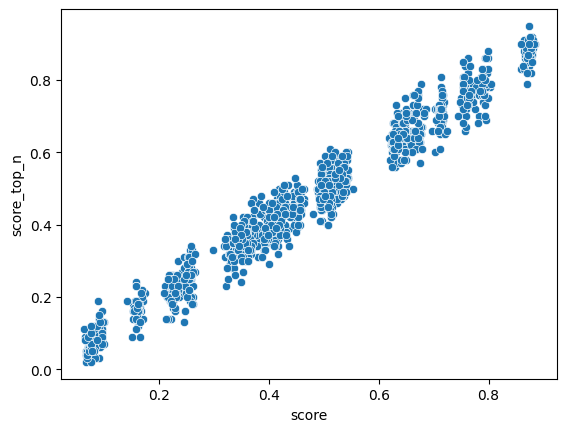

In [137]:
# plot
sns.scatterplot(data=model_item_scores_LOT, x='score', y='score_top_n')
plt.show()

In [138]:
# rename LOT round column to "item" to fit to all_data
model_item_scores_LOT = model_item_scores_LOT.rename(columns = {"round": "item"})

In [139]:
# add_new_df
all_data = pd.concat([all_data, model_item_scores_LOT], ignore_index=True)


LOT unvollständig!!!

## MPL TASK

In [140]:
# load data
MPL_data = load_dataframes(task_name="MPL")
MPL_human_data = pd.read_csv("orig_human_data/mpl.csv")

Merged DataFrame shape: (4569180, 10)
Total models: 46


In [141]:
# normalise answer option sum to one
MPL_data["prob_1"] = np.exp(MPL_data["log_prob_lot_1"])/(np.exp(MPL_data["log_prob_lot_1"]) + np.exp(MPL_data["log_prob_lot_2"]))
MPL_data["prob_2"] = np.exp(MPL_data["log_prob_lot_2"])/(np.exp(MPL_data["log_prob_lot_1"]) + np.exp(MPL_data["log_prob_lot_2"]))

In [142]:
# filter out probability LLM assigned to real item answer 
MPL_data=filter_pred_prob_including_key_logic(MPL_data, "lot_1_key", "lot_2_key")

In [143]:
# Merge only selected columns from DFD_human_data
MPL_data = MPL_data.merge(
    MPL_human_data[["partid", "dp", "decision", "R"]],
    left_on=["participant", "problem", "decision"],
    right_on=["partid", "dp", "decision"],
    how="left"
)

# Drop duplicate key columns if you don’t need them anymore
MPL_data = MPL_data.drop(columns=["partid",  "dp"])


In [144]:
# produce df with one value per model per item -------------------------------------------------------
def get_LLM_value_per_item(data):
    grouped = data.groupby(["experiment", "model", "problem", "decision"])
    prob_sum = grouped["prob_pred"].sum()
    
    # compute weighted mean
    scoreR = (grouped["R"].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum()) / prob_sum)
    
    # combine into one DataFrame
    result = pd.concat([scoreR], axis=1).reset_index()
    result.columns = ["experiment", "model", "problem", "decision", "score"]
    
    return result

# produce df with one value per model per item for top n version --------------------------------------------------
def get_LLM_value_per_item_top_n(data, human_col = "R"):
    new_df = (
    data.groupby(["experiment", "model", "problem", "decision"])[[human_col, "prob_pred"]]
      .apply(lambda group: compute_top_n_weighted_score(group, human_col=human_col))
      .reset_index(name="score_top_n")
    )
    return(new_df)

model_item_scores_MPL = get_LLM_value_per_item(MPL_data)
model_item_scores_MPL_top_n = get_LLM_value_per_item_top_n(MPL_data, human_col="R")

# Merge them on the grouping keys
model_item_scores_MPL = model_item_scores_MPL.merge(
    model_item_scores_MPL_top_n,
    on=["experiment", "model", "problem", "decision"],
    how="inner" 
)

In [145]:
model_item_scores_MPL

,experiment,model,problem,decision,score,score_top_n
0,MPL task,Apertus-70B-Instruct-2509,1,1,0.027972,0.02
1,MPL task,Apertus-70B-Instruct-2509,1,2,0.042430,0.04
2,MPL task,Apertus-70B-Instruct-2509,1,3,0.041865,0.06
3,MPL task,Apertus-70B-Instruct-2509,1,4,0.098211,0.13
4,MPL task,Apertus-70B-Instruct-2509,1,5,0.264267,0.21
...,...,...,...,...,...,...
3031,MPL task,zephyr-7b-beta,7,2,0.203456,0.26
3032,MPL task,zephyr-7b-beta,7,3,0.467823,0.50
3033,MPL task,zephyr-7b-beta,7,4,0.772868,0.78
3034,MPL task,zephyr-7b-beta,7,5,0.898102,0.90


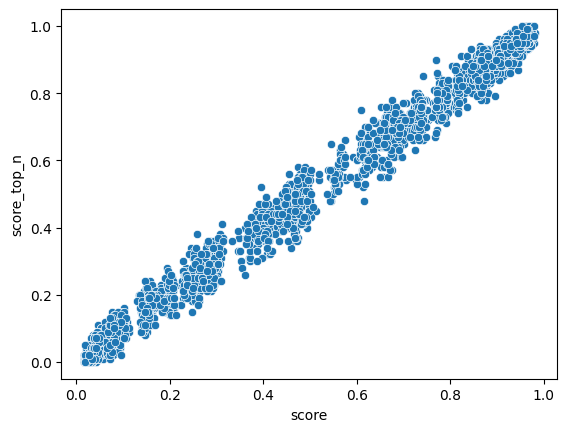

In [146]:
# plot
sns.scatterplot(data=model_item_scores_MPL, x='score', y='score_top_n')
plt.show()

In [147]:
# add item columns to MPL data that fits round and decision number (to have one unique identifier)
model_item_scores_MPL["item"] = model_item_scores_MPL.apply(lambda row: [row["problem"], row["decision"]], axis=1)
model_item_scores_MPL = model_item_scores_MPL.drop(columns=["problem", "decision"])

In [148]:
# add_new_df
all_data = pd.concat([all_data, model_item_scores_MPL], ignore_index=True)


# Save final complete data

In [ ]:
# save data
all_data.to_csv('processed_data/items_per_LLM.csv', index=False)
#all_data.to_csv("processed_data/items_per_LLM_random_simulation.csv", index=False)
#all_data.to_csv("processed_data/items_per_LLM_semi_random_simulation.csv", index=False)


In [150]:
all_data

,experiment,model,item,score,score_top_n,category,H_score,score_expected
0,AUDIT scale,Apertus-70B-Instruct-2509,1,0.931331,0.930000,NaN,NaN,NaN
1,AUDIT scale,Apertus-70B-Instruct-2509,2,2.358559,2.319578,NaN,NaN,NaN
2,AUDIT scale,Apertus-70B-Instruct-2509,3,0.750596,0.719092,NaN,NaN,NaN
3,AUDIT scale,Apertus-70B-Instruct-2509,4,1.229221,1.279627,NaN,NaN,NaN
4,AUDIT scale,Apertus-70B-Instruct-2509,5,0.373359,0.361620,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
21187,MPL task,zephyr-7b-beta,"[7, 2]",0.203456,0.260000,NaN,NaN,NaN
21188,MPL task,zephyr-7b-beta,"[7, 3]",0.467823,0.500000,NaN,NaN,NaN
21189,MPL task,zephyr-7b-beta,"[7, 4]",0.772868,0.780000,NaN,NaN,NaN
21190,MPL task,zephyr-7b-beta,"[7, 5]",0.898102,0.900000,NaN,NaN,NaN
